During the DES Sims workshop I'm working on a $w(\theta)$ emulator. We'd like to see how the redMagic HOD emulator fits the sample from a simulation and if it matches the HOD. The last step before running chains is finding hyperparams. This will be a little painful but should work. 

In [1]:
from pearce.emulator import OriginalRecipe, ExtraCrispy
from pearce.mocks import cat_dict
import numpy as np
from os import path

In [2]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [3]:
training_dir = '/u/ki/swmclau2/des/PearceLHC_wt_z/'

em_method = 'gp'
split_method = 'random'

In [4]:
%%bash
ls -d ~/des/PearceLHC_wt_z/*

/u/ki/swmclau2/des/PearceLHC_wt_z/a_0.54780
/u/ki/swmclau2/des/PearceLHC_wt_z/a_0.59260
/u/ki/swmclau2/des/PearceLHC_wt_z/a_0.65800
/u/ki/swmclau2/des/PearceLHC_wt_z/a_0.73060
/u/ki/swmclau2/des/PearceLHC_wt_z/a_0.81120


In [5]:
a = 0.81120
z = 1/(1+a)

In [6]:
fixed_params = {'z':z}#, 'r':0.18477483}

In [7]:
emu = OriginalRecipe(training_dir, method = em_method, fixed_params=fixed_params, independent_variable='wt')

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/pearce/emulator/emu.py:165: UserWarning: WARNING: NaN detected. Skipping point in /u/ki/swmclau2/des/PearceLHC_wt_z/a_0.65800/cov_job090_HOD000.npy
  warnings.warn('WARNING: NaN detected. Skipping point in %s' % cov_file)


In [8]:
emu.scale_bin_centers

array([ 0.04738073,  0.06037608,  0.07693572,  0.09803727,  0.12492644,
        0.15919064,  0.20285265,  0.25849006,  0.32938742,  0.41973014,
        0.53485162,  0.68154804,  0.86847962,  1.10668185,  1.41021701,
        1.79700426,  2.28987757,  2.91793371,  3.71824994])

In [9]:
emu._ordered_params

OrderedDict([('logMmin', (11.7, 12.5)),
             ('sigma_logM', (0.2, 0.7)),
             ('logM0', (10, 13)),
             ('logM1', (13.1, 14.3)),
             ('alpha', (0.75, 1.25)),
             ('f_c', (0.1, 0.5)),
             ('mean_occupation_satellites_assembias_param1', (-1.0, 1.0)),
             ('mean_occupation_centrals_assembias_param1', (-1.0, 1.0)),
             ('disp_func_slope_satellites', (-1.0, 1.0)),
             ('disp_func_slope_centrals', (-1.0, 1.0)),
             ('r', (0.047380730000000003, 3.7182499399999998))])

In [10]:
#print emu.x[0][np.isnan(emu.y[0])]
print np.sum(emu.y<0)
print np.sum(emu.y>=0)

392
8158


/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/pearce/emulator/emu.py:385: UserWarning: One value for r is outside the bounds (0.047, 3.718) of the emulator.
  pname, plow, phigh))
/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


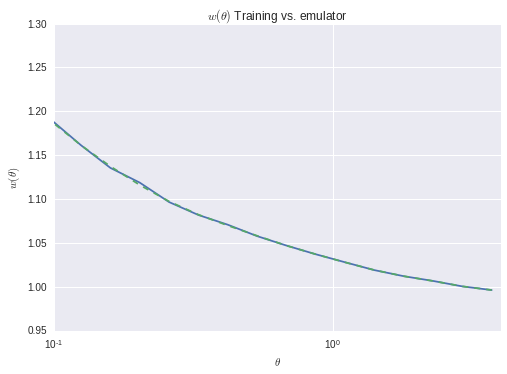

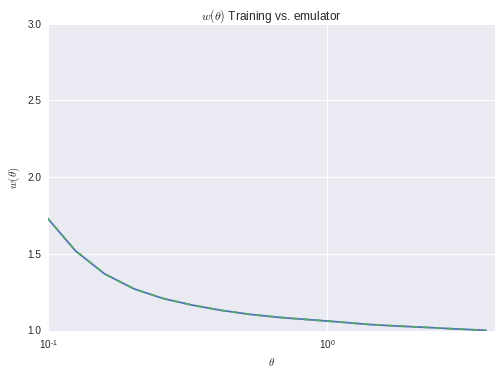

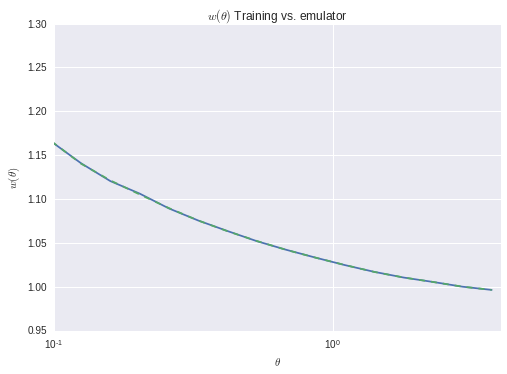

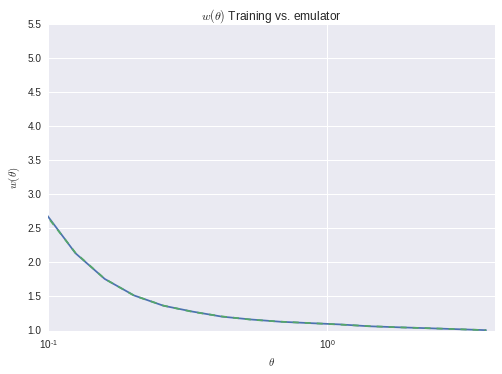

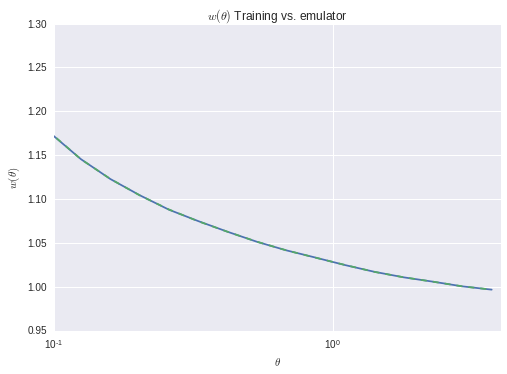

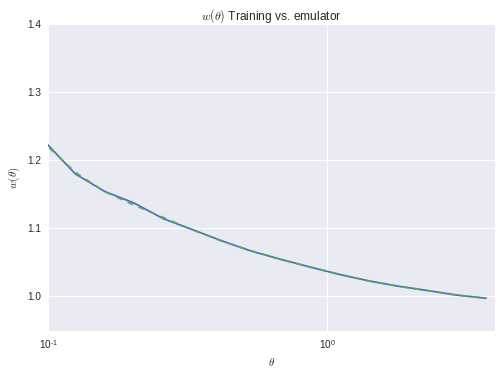

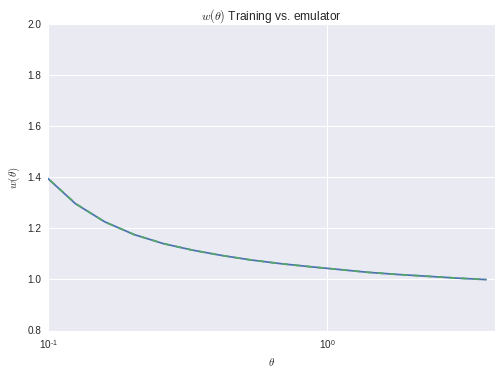

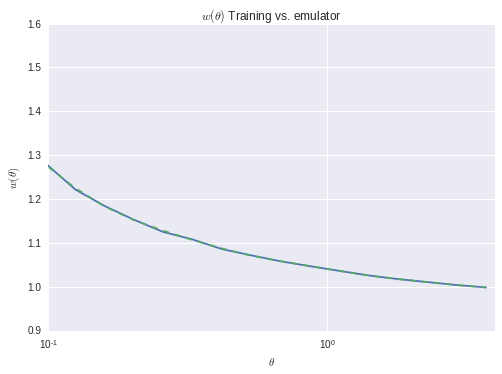

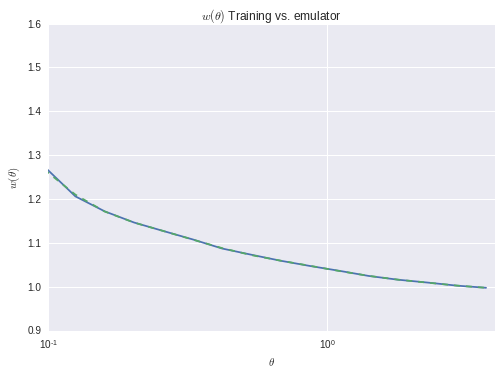

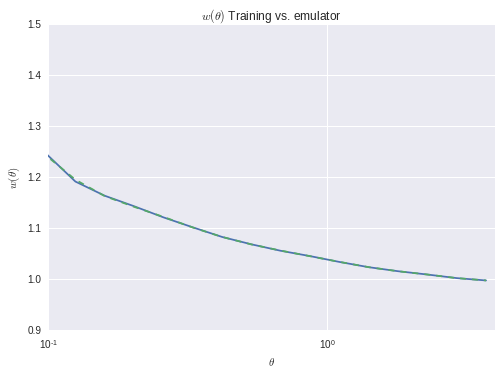

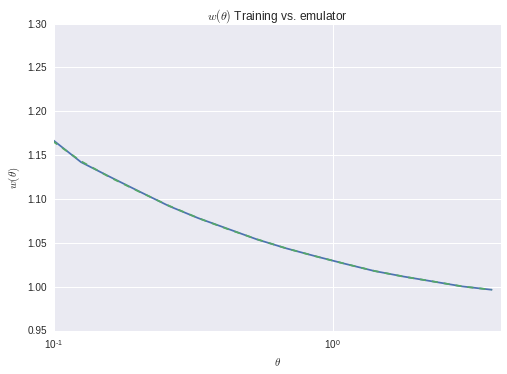

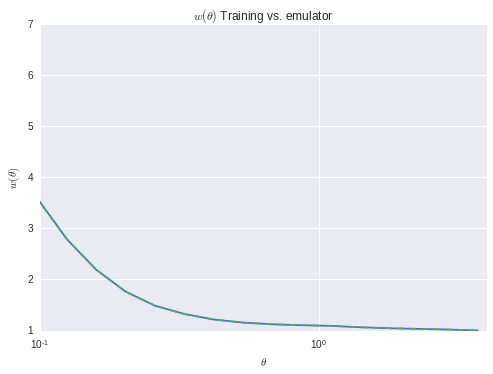

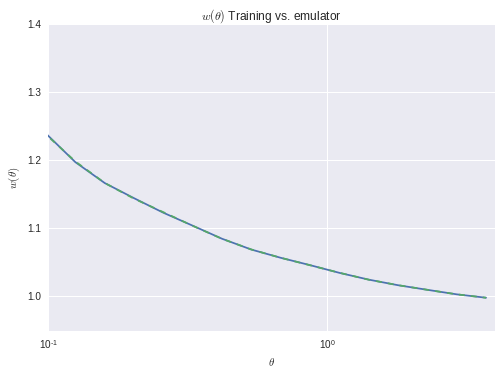

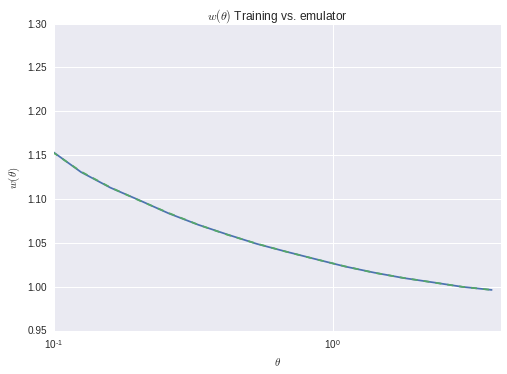

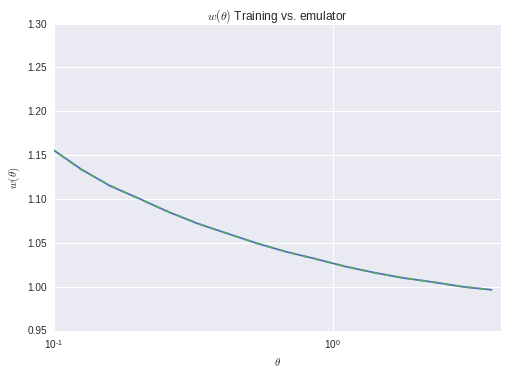

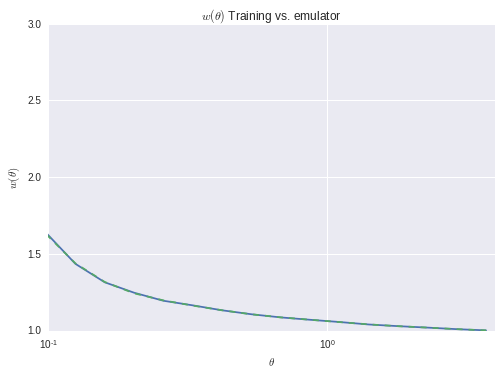

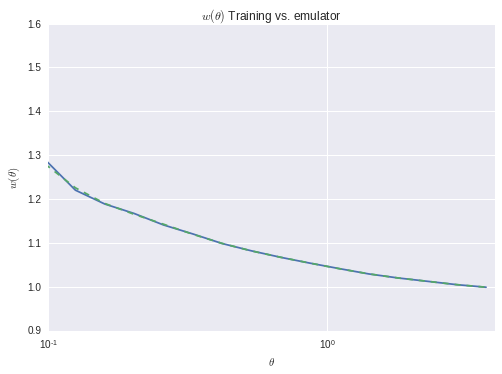

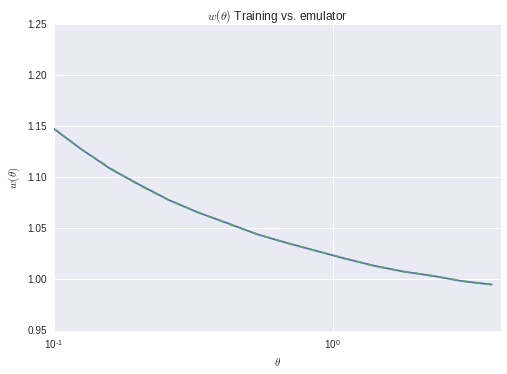

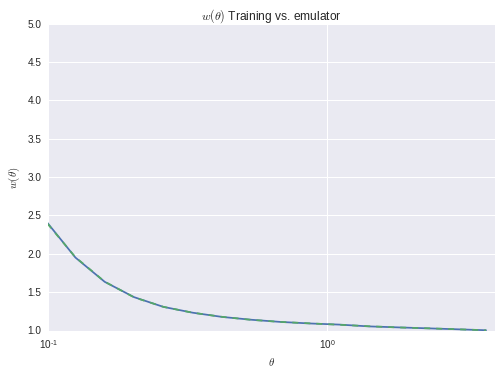

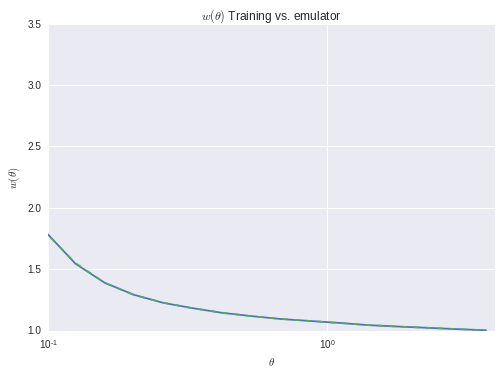

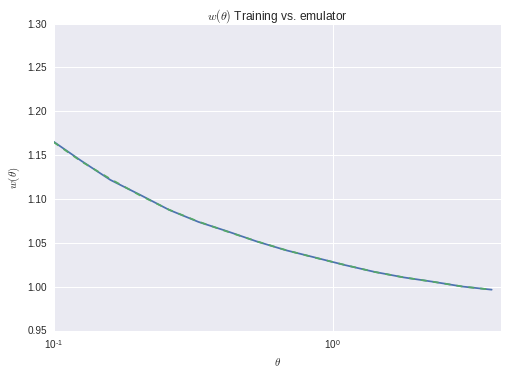

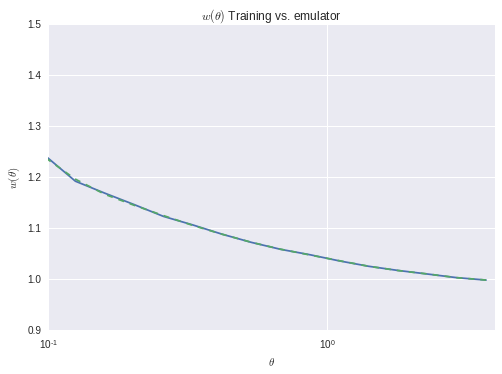

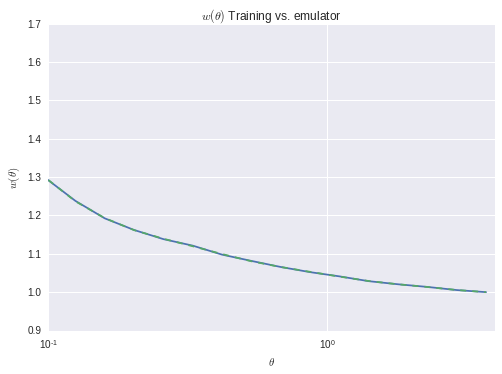

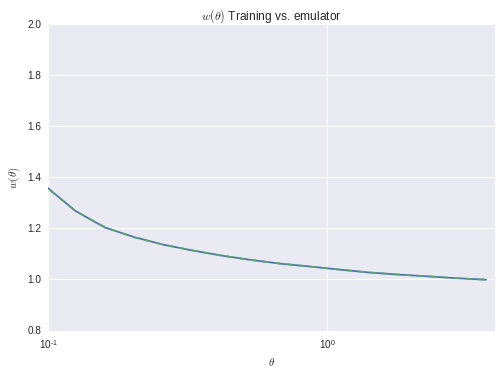

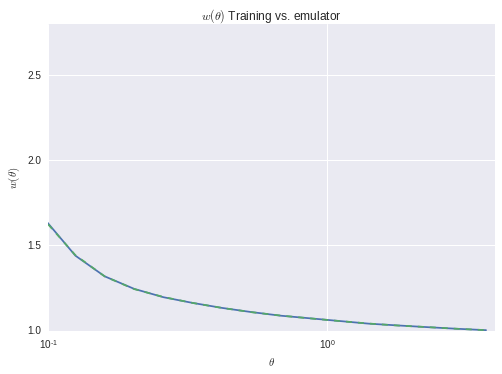

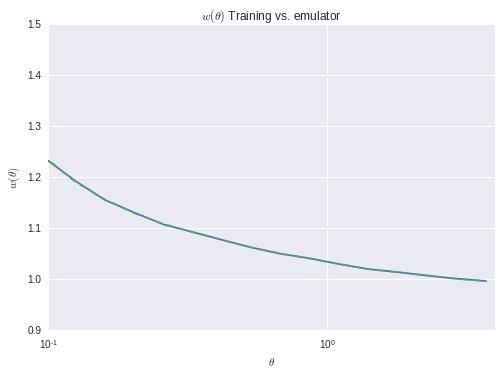

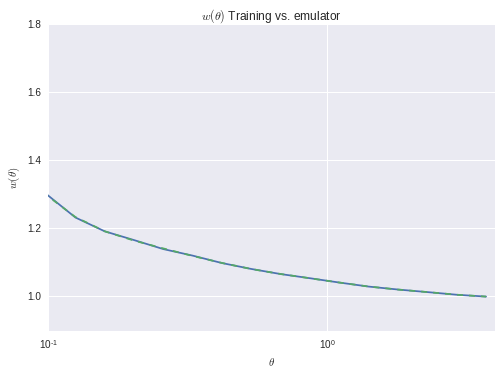

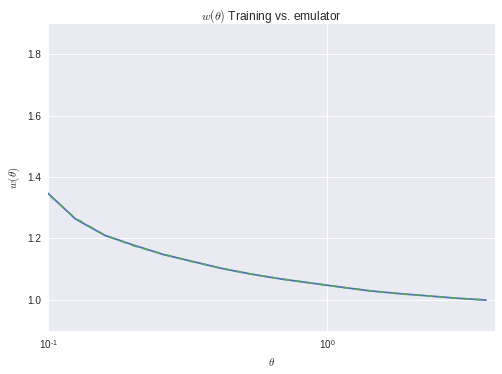

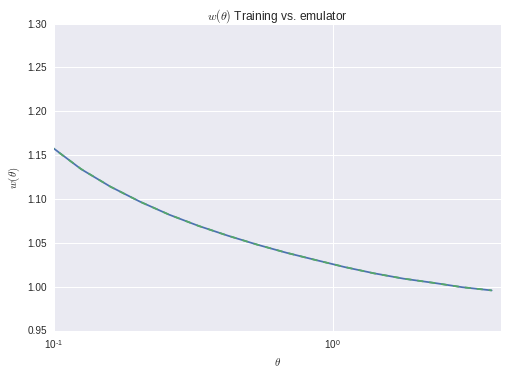

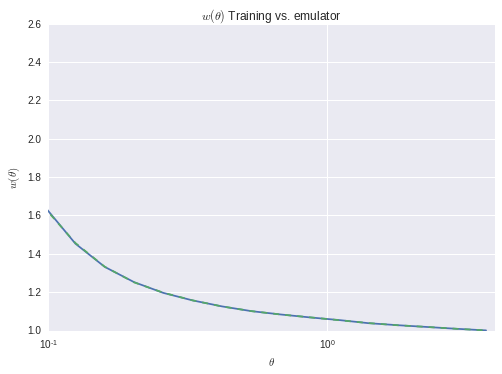

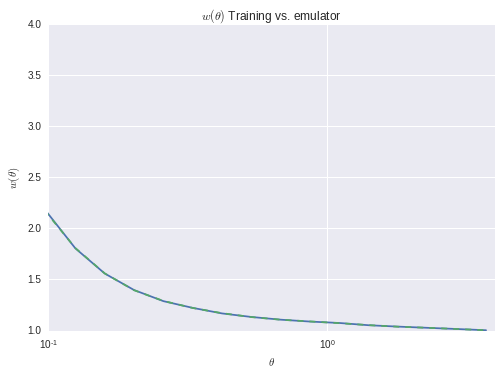

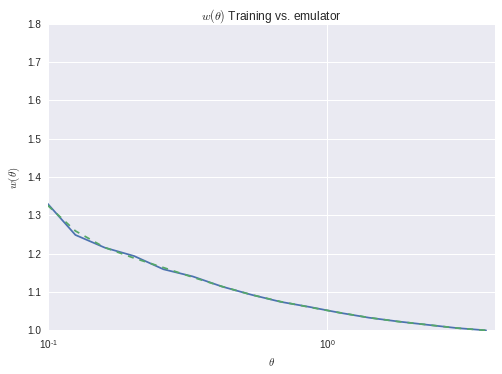

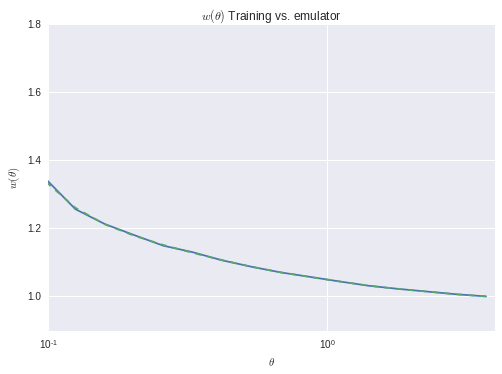

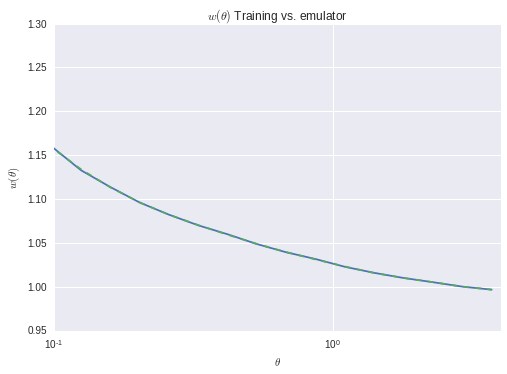

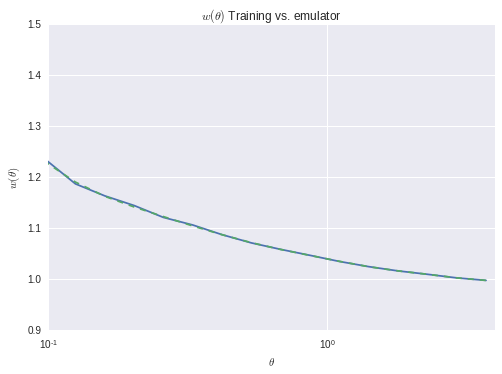

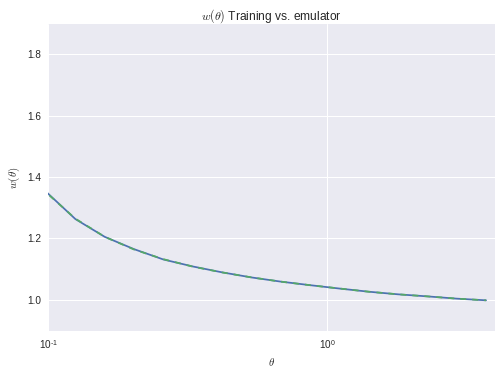

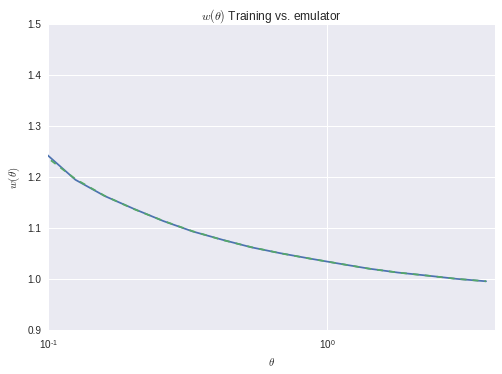

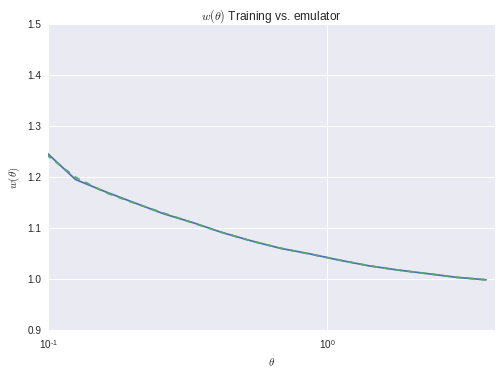

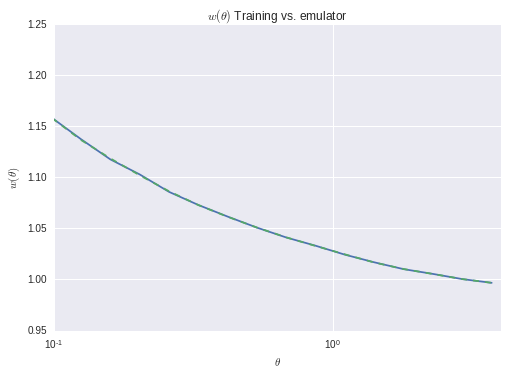

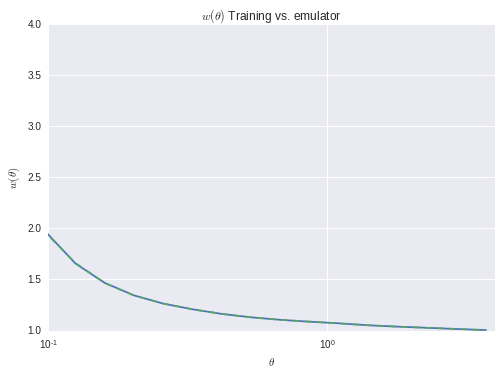

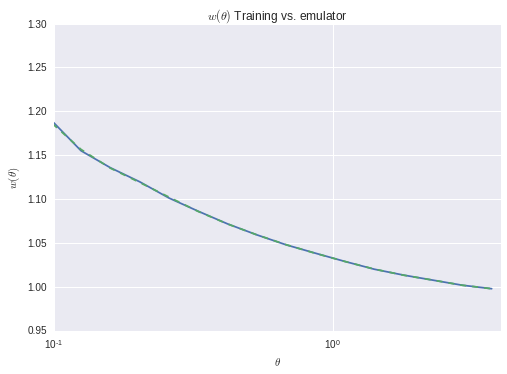

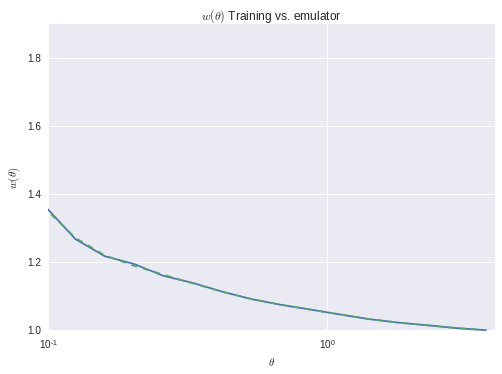

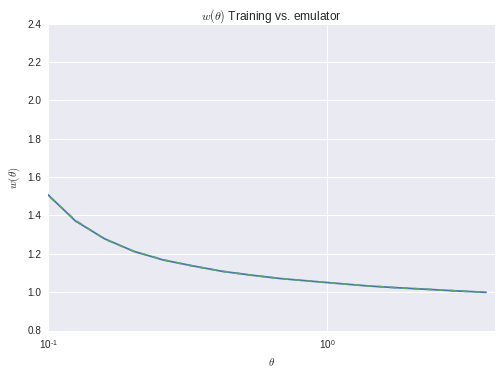

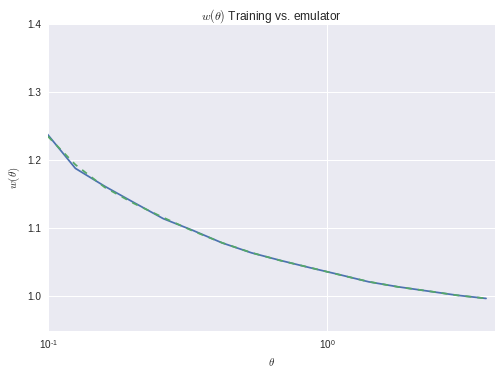

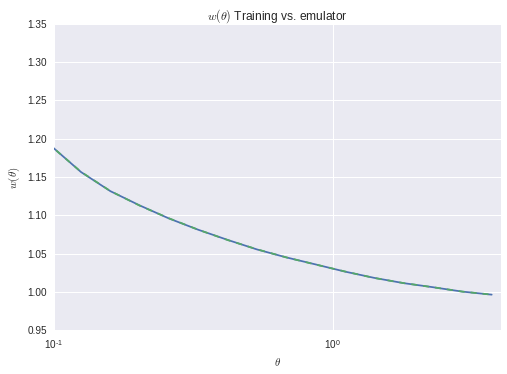

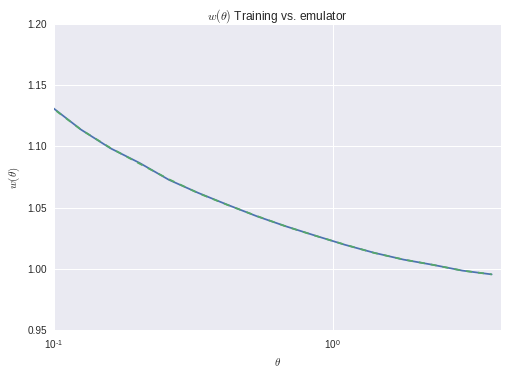

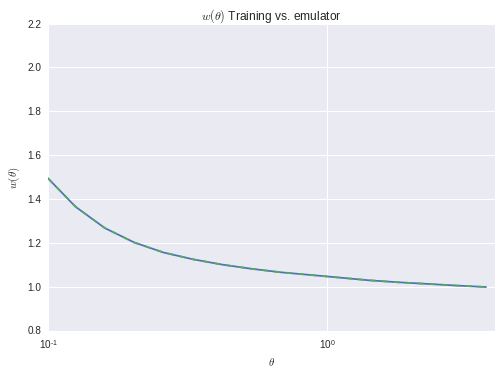

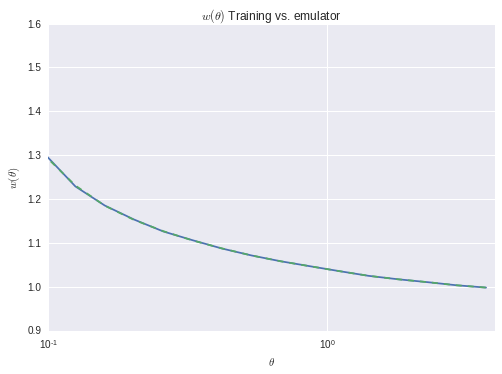

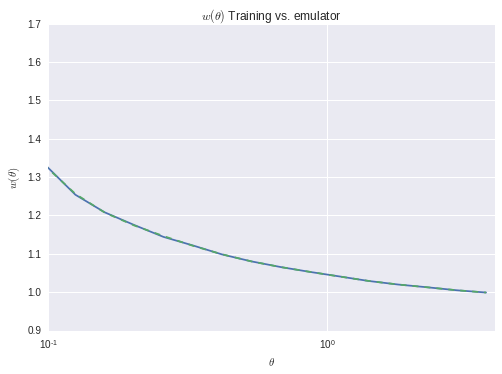

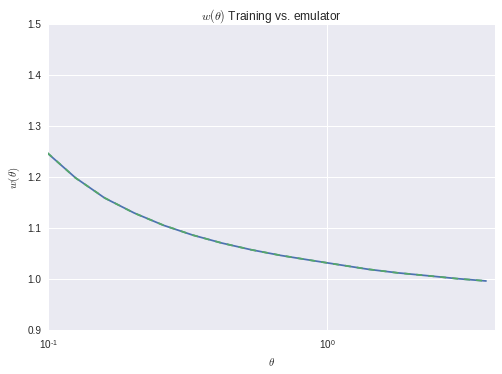

In [11]:
binlen = 19
for b in xrange(50):
    plt.plot(emu.scale_bin_centers, emu.y[b*binlen:(b+1)*binlen]+1)
    params = dict(zip(emu._ordered_params.keys(), emu.x[b*binlen+1,:-1]))
    pred = emu.emulate_wrt_r(params, emu.scale_bin_centers)[0]
    plt.plot(emu.scale_bin_centers, 1+pred, ls = '--')
    
    #plt.ylim([0.9, 1.5])
    plt.xscale('log')
    plt.legend(loc='best')
    plt.xlim([0.1, 4])
    plt.title(r'$w(\theta)$ Training vs. emulator')
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$w(\theta)$')
    
    plt.show()

In [12]:
from pearce.mocks import compute_prim_haloprop_bins, cat_dict

In [13]:
cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[a]}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

cat.load_catalog(a)
#halo_masses = cat.halocat.halo_table['halo_mvir']

In [14]:
cat.load_model(a, 'abRedMagic')

In [15]:
binno = 1
params = {pname:val for pname, val in zip(emu._ordered_params.iterkeys(), emu.x[binno*binlen,:-1])}
cat.populate(params)

831713
0.499984670663
[0 0 0 ..., 0 0 0]
[ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]
********************
0.968285705183
0.0

831713
0.499984670663
[0 0 0 ..., 0 0 0]
[ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]
********************
0.968285705183
0.0

298271
0.49996647569
[0 0 0 ..., 0 0 0]
[ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]
********************
0.916237834866
0.0



wt = cat.calc_wt(theta_bins, do_jackknife=False,n_cores=1)

In [16]:
theta_bins = np.logspace(np.log10(2.5), np.log10(250), 20)/60
tpoints = (theta_bins[1:]+theta_bins[:-1])/2

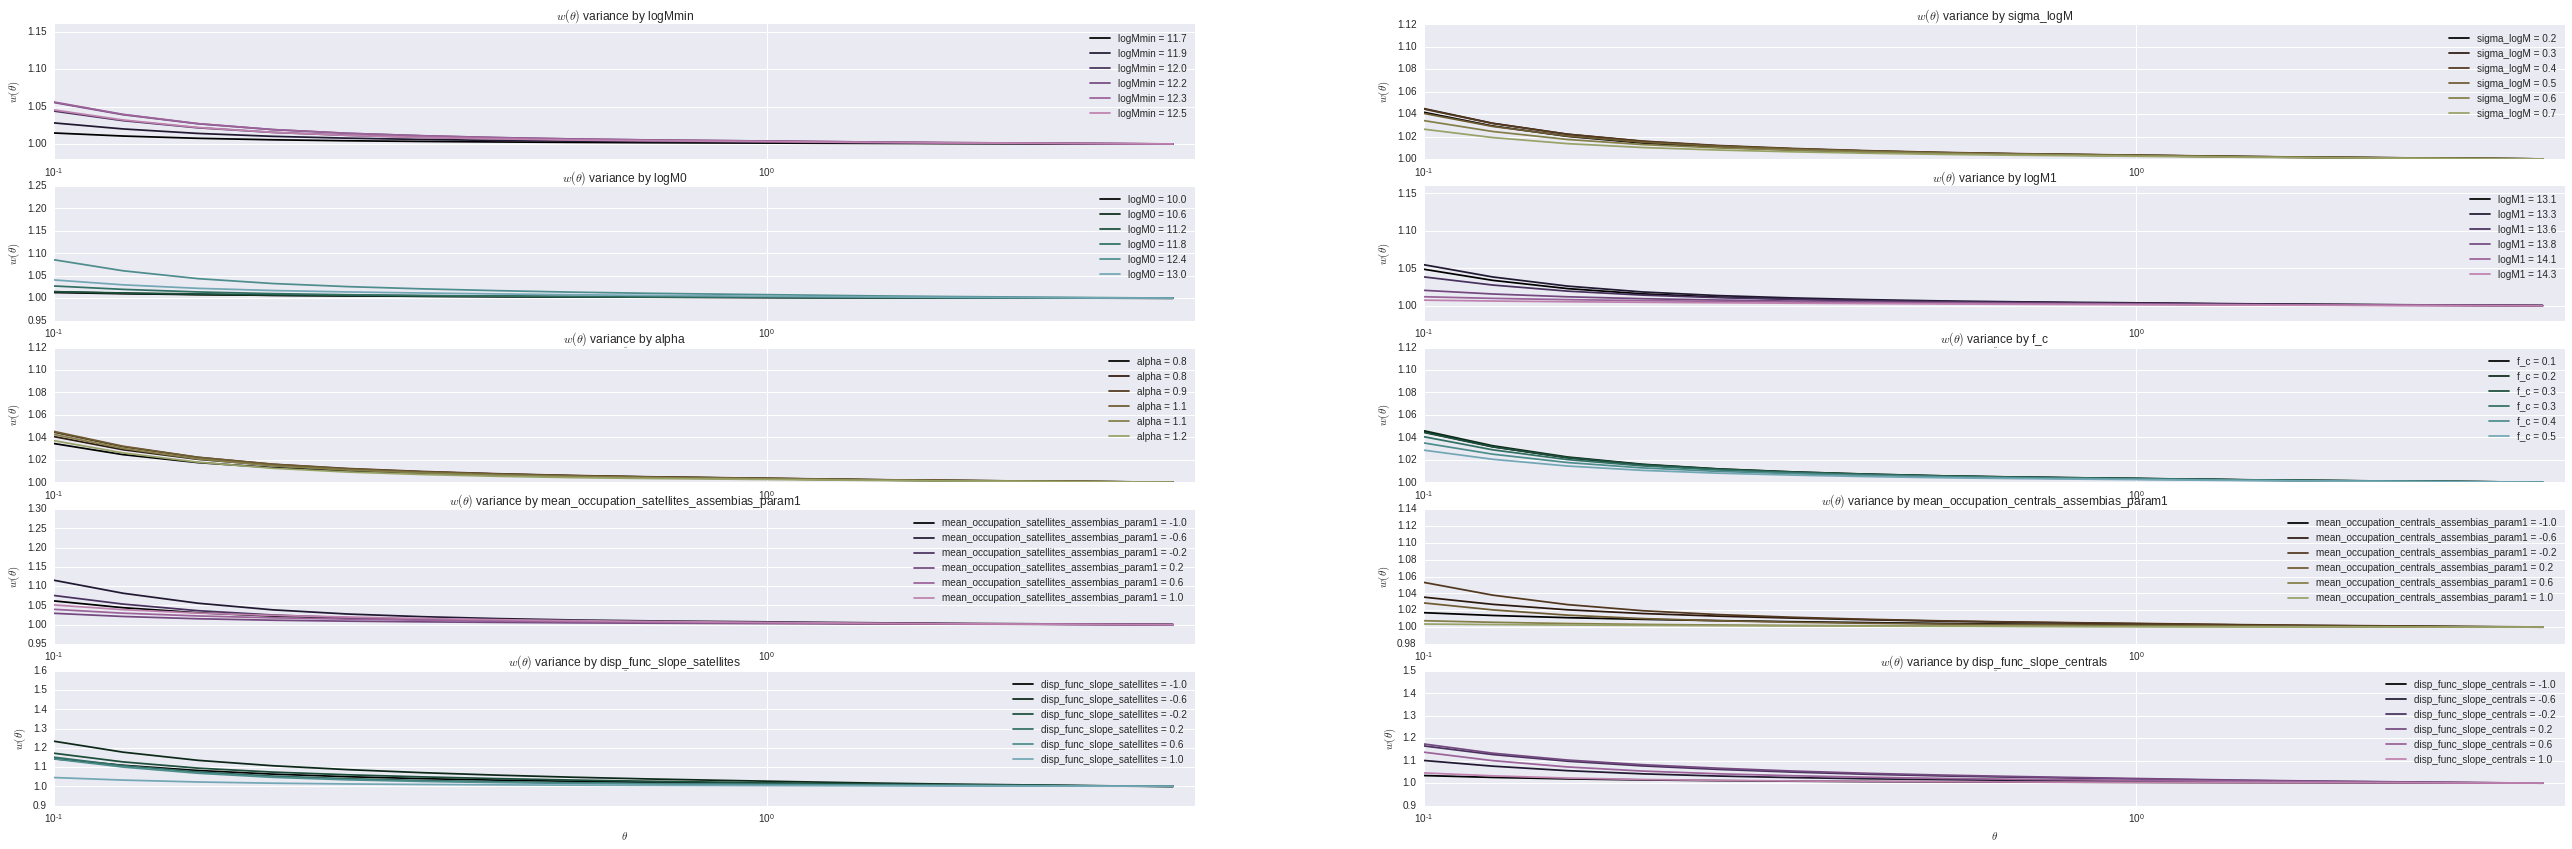

In [17]:
fig = plt.figure(figsize=(45,14))


emulation_point = [('f_c', 0.233), ('logM0', 12.0), ('sigma_logM', 0.333),
                    ('alpha', 1.053),('logM1', 13.5), ('logMmin', 12.033)]

em_params = dict(emulation_point)

em_params.update(fixed_params)
del em_params['z']

fixed_params2 = {'mean_occupation_satellites_assembias_param1':0.0,
                'mean_occupation_centrals_assembias_param1':0.0,
                'disp_func_slope_satellites':1.0,
                'disp_func_slope_centrals':1.0}

for idx, (param, bounds) in enumerate(emu._ordered_params.iteritems()):
    if param == 'r':
        continue
    wt_vals = []
    new_em_params = {}
    new_em_params.update(em_params)
    new_em_params.update(fixed_params2)
    for v in np.linspace(bounds[0], bounds[1], 6):
        new_em_params[param] = v
        wt_vals.append(emu.emulate_wrt_r(new_em_params, tpoints))
    wt_vals = np.array(wt_vals)
    
    pal = sns.cubehelix_palette(wt_vals.shape[0], start=idx, rot=0.3,\
                            dark=0.0, light=.60,reverse = True)
    #sns.palplot(pal)

    sns.set_palette(pal)

    #sns.set_style("darkgrid", {"axes.facecolor": "0.85"})
    plt.subplot(5,2,idx+1)

    for color, wt, v in zip(pal, wt_vals,np.linspace(bounds[0], bounds[1], 6) ):
        plt.plot(tpoints, 1+wt[0,:], color = color, label = r'%s = %.1f'%(param,v) )
    #plt.loglog()
    plt.xscale('log')
    plt.legend(loc='best')
    plt.xlim([0.1, 4])
    plt.title(r'$w(\theta)$ variance by %s'%param)
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$w(\theta)$')
plt.show()

In [18]:
import scipy.optimize as op
from itertools import izip

In [19]:
def nll(p):
    # Update the kernel parameters and compute the likelihood.
    # params are log(a) and log(m)
    #ll = 0
    #for emulator, _y in izip(self._emulators, self.y):
    #    emulator.kernel[:] = p
    #    ll += emulator.lnlikelihood(_y, quiet=True)
    emu._emulator.kernel[:] = p
    print p
    ll= emu._emulator.lnlikelihood(emu.y, quiet=False)

    # The scipy optimizer doesn't play well with infinities.
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    # Update the kernel parameters and compute the likelihood.
    #gll = 0
    #for emulator, _y in izip(self._emulators, self.y):
    #    emulator.kernel[:] = p
    #    gll += emulator.grad_lnlikelihood(_y, quiet=True)
    emu._emulator.kernel[:] = p
    gll = emu._emulator.grad_lnlikelihood(emu.y, quiet=True)
    return -gll

In [20]:
emu.goodness_of_fit(training_dir)

0.99987757741643801

In [21]:
p0 = emu._emulator.kernel.vector

In [22]:
p0 = np.log(np.random.rand(emu._emulator.kernel.vector.shape[0]))
results = op.minimize(nll, p0, jac=grad_nll)

KeyboardInterrupt: 

In [ ]:
print results.x
print results.success

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklean.metrics import make_scorer

In [ ]:
def my_loss_func(predictions, emu.y)